# Word Level Federated Text Generation with Stack Overflow with and without Pretrained Word Embeddings
- Joel Stremmel
- 02-10-20
- GCP 

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer in the LSTM is optionally initialized with either GloVe or FastText Embeddings.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !sudo pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [5]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [9]:
VOCAB_SIZE = 10000
BATCH_SIZE = 4
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 20
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 300
# EMBEDDING_PATH = ''
EMBEDDING_PATH = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
# EMBEDDING_PATH = '../word_embeddings/fasttext/wiki-news-{}d-1M.vec'.format(EMBEDDING_DIM)

RNN_UNITS = 600

### Load and Preprocess Word Level Datasets

In [10]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [11]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [12]:
pad, oov, bos, eos = dataset.get_special_tokens(vocab_size=VOCAB_SIZE)

In [13]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [14]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [15]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [16]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- Or [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If `EMBEDDING_PATH` is an empy string, the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.

In [17]:
if EMBEDDING_PATH:
    embedding_matrix=embeddings.create_matrix_from_pretrained_embeddings(
        embedding_path=EMBEDDING_PATH,
        embedding_dim=EMBEDDING_DIM,
        word2idx=word2idx)
else:
    embedding_matrix = 'uniform'

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:64: UserWarning: Words from dataset with no embedding: 1303
  warnings.warn('Words from dataset with no embedding: {}'.format(missing_words))


### Load or Build the Model and Try Generating Some Text

In [18]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

"how are you today misspelled disappear cropped purpose some constants translucent significant approved execute source exposing recommend treemap grant trace normalize nslog sales ld sane instagram nth-child nslog arithmetic packed plunkr fundamental isn't a3 needs psql archive regenerated bucket bus one's constant adjacent minutes stand trimmed 1 scores kb there they're reverse demonstrated belongs"

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [19]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [20]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [21]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [22]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [23]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 205ms/step - loss: 6.2816 - num_tokens: 129088.0000 - num_tokens_no_oov: 124907.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.7467e-06 - accuracy_no_oov: 8.0060e-06 - accuracy_no_oov_no_eos: 8.5239e-06
Sampling 10 new clients.
Round: 0
   Loss: 3.94500875
   num_batches: 1016
   num_examples: 4044
   num_tokens: 50126
   num_tokens_no_oov: 48758
   accuracy: 0.09634
   accuracy_no_oov: 0.09812
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 211ms/step - loss: 6.1783 - num_tokens: 127231.0000 - num_tokens_no_oov: 122931.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0105 - accuracy_no_oov: 0.0109 - accuracy_no_oov_no_eos: 0.0038
Sampling 10 new clients.
Round: 1
   Loss: 4.52525377
   num_batches: 793
   num_examples: 3150
   num_tokens: 44349
   num_tokens_no_oov: 42853
   accuracy: 0.08099
   accuracy_no_oov: 0.07883
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 207ms/step - loss: 6.3752 - num_tokens: 133338.0000 - num_tokens_no_oov: 129057.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.7499e-05 - accuracy_no_oov: 3.8743e-05 - accuracy_no_oov_no_eos: 1.6414e-05
Sampling 10 new clients.
Round: 2
   Loss: 4.16995382
   num_batches: 703
   num_examples: 2797
   num_tokens: 37226
   num_tokens_no_oov: 36356
   accuracy: 0.08620
   accuracy_no_oov: 0.08805
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 208ms/step - loss: 6.2921 - num_tokens: 133844.0000 - num_tokens_no_oov: 129194.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 3
   Loss: 4.72816229
   num_batches: 527
   num_examples: 2097
   num_tokens: 30199
   num_tokens_no_oov: 29140
   accuracy: 0.05864
   accuracy_no_oov: 0.05662
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 209ms/step - loss: 6.2744 - num_tokens: 137490.0000 - num_tokens_no_oov: 132464.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 3.81840873
   num_batches: 2064
   num_examples: 8240
   num_tokens: 113210
   num_tokens_no_oov: 110013
   accuracy: 0.13997
   accuracy_no_oov: 0.13980
Evaluating before training round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 22s 224ms/step - loss: 6.0538 - num_tokens: 135735.0000 - num_tokens_no_oov: 131817.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 5
   Loss: 4.18629122
   num_batches: 526
   num_examples: 2080
   num_tokens: 27377
   num_tokens_no_oov: 26576
   accuracy: 0.07755
   accuracy_no_oov: 0.07947
Evaluating before training round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 22s 217ms/step - loss: 5.7540 - num_tokens: 132165.0000 - num_tokens_no_oov: 128041.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.4376e-04 - accuracy_no_oov: 1.4839e-04 - accuracy_no_oov_no_eos: 1.5747e-04
Sampling 10 new clients.
Round: 6
   Loss: 3.30999494
   num_batches: 1270
   num_examples: 5063
   num_tokens: 61468
   num_tokens_no_oov: 60041
   accuracy: 0.14861
   accuracy_no_oov: 0.15008
Evaluating before training round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 22s 223ms/step - loss: 5.4645 - num_tokens: 128807.0000 - num_tokens_no_oov: 124777.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0215 - accuracy_no_oov: 0.0222 - accuracy_no_oov_no_eos: 0.0149
Sampling 10 new clients.
Round: 7
   Loss: 4.18850183
   num_batches: 681
   num_examples: 2707
   num_tokens: 37831
   num_tokens_no_oov: 36634
   accuracy: 0.10679
   accuracy_no_oov: 0.10643
Evaluating before training round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 213ms/step - loss: 5.8332 - num_tokens: 140398.0000 - num_tokens_no_oov: 136237.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0360 - accuracy_no_oov: 0.0371 - accuracy_no_oov_no_eos: 0.0269
Sampling 10 new clients.
Round: 8
   Loss: 4.06158781
   num_batches: 398
   num_examples: 1582
   num_tokens: 20096
   num_tokens_no_oov: 19461
   accuracy: 0.08375
   accuracy_no_oov: 0.08432
Evaluating before training round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 207ms/step - loss: 5.7287 - num_tokens: 141216.0000 - num_tokens_no_oov: 135431.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0586 - accuracy_no_oov: 0.0611 - accuracy_no_oov_no_eos: 0.0552
Sampling 10 new clients.
Round: 9
   Loss: 3.53167200
   num_batches: 946
   num_examples: 3769
   num_tokens: 45429
   num_tokens_no_oov: 43893
   accuracy: 0.12195
   accuracy_no_oov: 0.11799
Evaluating before training round #10 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 22s 215ms/step - loss: 5.4457 - num_tokens: 137064.0000 - num_tokens_no_oov: 132078.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0504 - accuracy_no_oov: 0.0523 - accuracy_no_oov_no_eos: 0.0391
Sampling 10 new clients.
Round: 10
   Loss: 4.21249104
   num_batches: 672
   num_examples: 2676
   num_tokens: 36999
   num_tokens_no_oov: 35792
   accuracy: 0.10979
   accuracy_no_oov: 0.10653
Evaluating before training round #11 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 212ms/step - loss: 5.4370 - num_tokens: 138891.0000 - num_tokens_no_oov: 134808.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0513 - accuracy_no_oov: 0.0529 - accuracy_no_oov_no_eos: 0.0410
Sampling 10 new clients.
Round: 11
   Loss: 3.69478726
   num_batches: 516
   num_examples: 2051
   num_tokens: 25809
   num_tokens_no_oov: 24956
   accuracy: 0.12383
   accuracy_no_oov: 0.12554
Evaluating before training round #12 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 214ms/step - loss: 4.9825 - num_tokens: 129452.0000 - num_tokens_no_oov: 125265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0765 - accuracy_no_oov: 0.0791 - accuracy_no_oov_no_eos: 0.0582
Sampling 10 new clients.
Round: 12
   Loss: 3.49156976
   num_batches: 745
   num_examples: 2966
   num_tokens: 35946
   num_tokens_no_oov: 34911
   accuracy: 0.13654
   accuracy_no_oov: 0.13703
Evaluating before training round #13 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 214ms/step - loss: 4.9958 - num_tokens: 131386.0000 - num_tokens_no_oov: 127116.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0872 - accuracy_no_oov: 0.0901 - accuracy_no_oov_no_eos: 0.0544
Sampling 10 new clients.
Round: 13
   Loss: 3.84284329
   num_batches: 576
   num_examples: 2291
   num_tokens: 29935
   num_tokens_no_oov: 29155
   accuracy: 0.12404
   accuracy_no_oov: 0.12485
Evaluating before training round #14 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 22s 223ms/step - loss: 4.9432 - num_tokens: 131588.0000 - num_tokens_no_oov: 127504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0975 - accuracy_no_oov: 0.1006 - accuracy_no_oov_no_eos: 0.0613
Sampling 10 new clients.
Round: 14
   Loss: 3.94420910
   num_batches: 774
   num_examples: 3082
   num_tokens: 41623
   num_tokens_no_oov: 40561
   accuracy: 0.13022
   accuracy_no_oov: 0.13091
Evaluating before training round #15 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 213ms/step - loss: 4.9231 - num_tokens: 132505.0000 - num_tokens_no_oov: 128317.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1002 - accuracy_no_oov: 0.1035 - accuracy_no_oov_no_eos: 0.0629
Sampling 10 new clients.
Round: 15
   Loss: 4.09805965
   num_batches: 1395
   num_examples: 5564
   num_tokens: 81407
   num_tokens_no_oov: 79078
   accuracy: 0.14357
   accuracy_no_oov: 0.13967
Evaluating before training round #16 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 22s 215ms/step - loss: 4.7803 - num_tokens: 129990.0000 - num_tokens_no_oov: 126111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1077 - accuracy_no_oov: 0.1109 - accuracy_no_oov_no_eos: 0.0676
Sampling 10 new clients.
Round: 16
   Loss: 3.51929379
   num_batches: 1284
   num_examples: 5123
   num_tokens: 66921
   num_tokens_no_oov: 64819
   accuracy: 0.16768
   accuracy_no_oov: 0.16682
Evaluating before training round #17 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 214ms/step - loss: 4.8156 - num_tokens: 131912.0000 - num_tokens_no_oov: 128109.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1119 - accuracy_no_oov: 0.1140 - accuracy_no_oov_no_eos: 0.0710
Sampling 10 new clients.
Round: 17
   Loss: 3.52864957
   num_batches: 660
   num_examples: 2628
   num_tokens: 32976
   num_tokens_no_oov: 32149
   accuracy: 0.15284
   accuracy_no_oov: 0.15422
Evaluating before training round #18 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 21s 212ms/step - loss: 4.5186 - num_tokens: 124714.0000 - num_tokens_no_oov: 121288.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1172 - accuracy_no_oov: 0.1193 - accuracy_no_oov_no_eos: 0.0755
Sampling 10 new clients.
Round: 18
   Loss: 3.25924134
   num_batches: 1626
   num_examples: 6489
   num_tokens: 81093
   num_tokens_no_oov: 78799
   accuracy: 0.18064
   accuracy_no_oov: 0.17807
Evaluating before training round #19 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 24s 237ms/step - loss: 4.7661 - num_tokens: 131971.0000 - num_tokens_no_oov: 127814.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1204 - accuracy_no_oov: 0.1219 - accuracy_no_oov_no_eos: 0.0766
Sampling 10 new clients.
Round: 19
   Loss: 3.87421584
   num_batches: 713
   num_examples: 2831
   num_tokens: 38643
   num_tokens_no_oov: 37702
   accuracy: 0.14096
   accuracy_no_oov: 0.14015


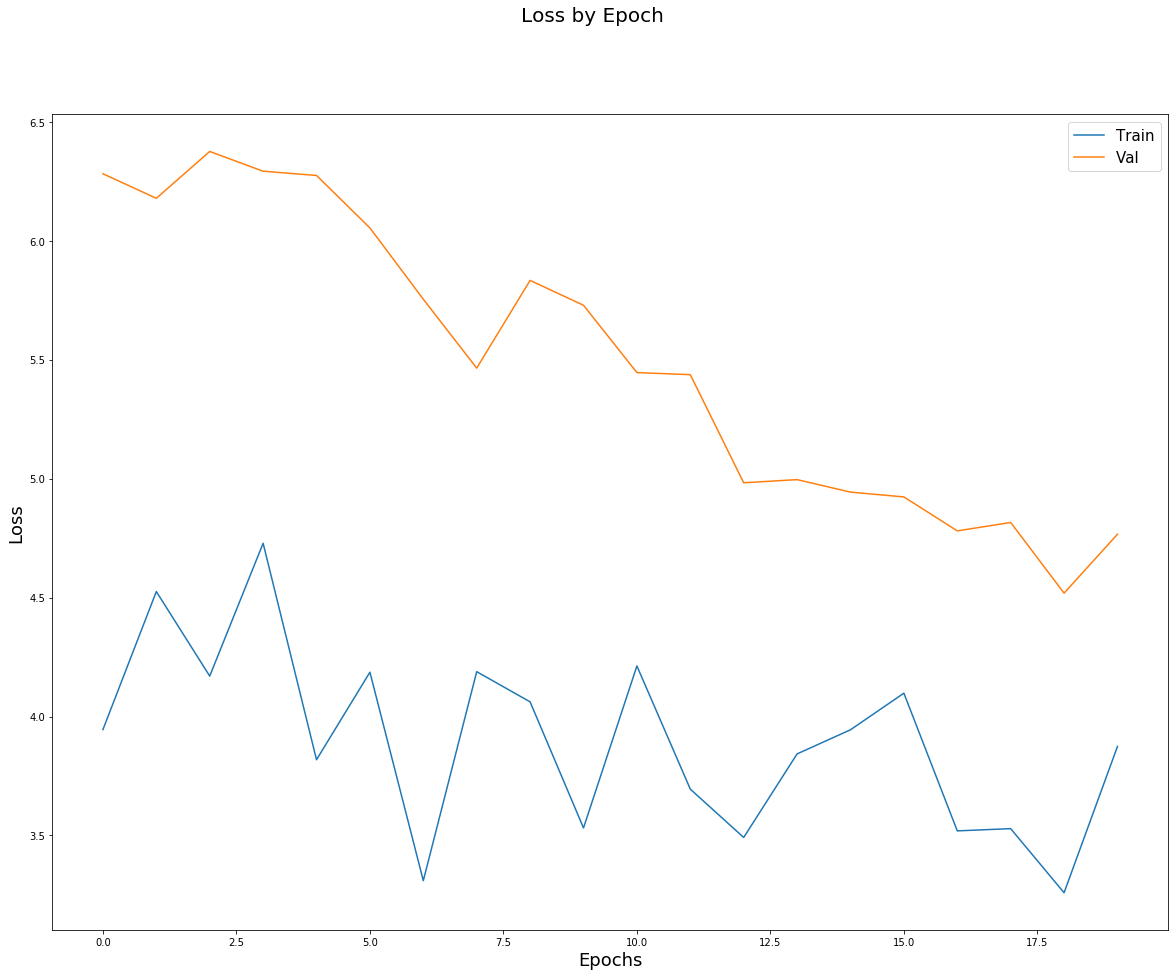

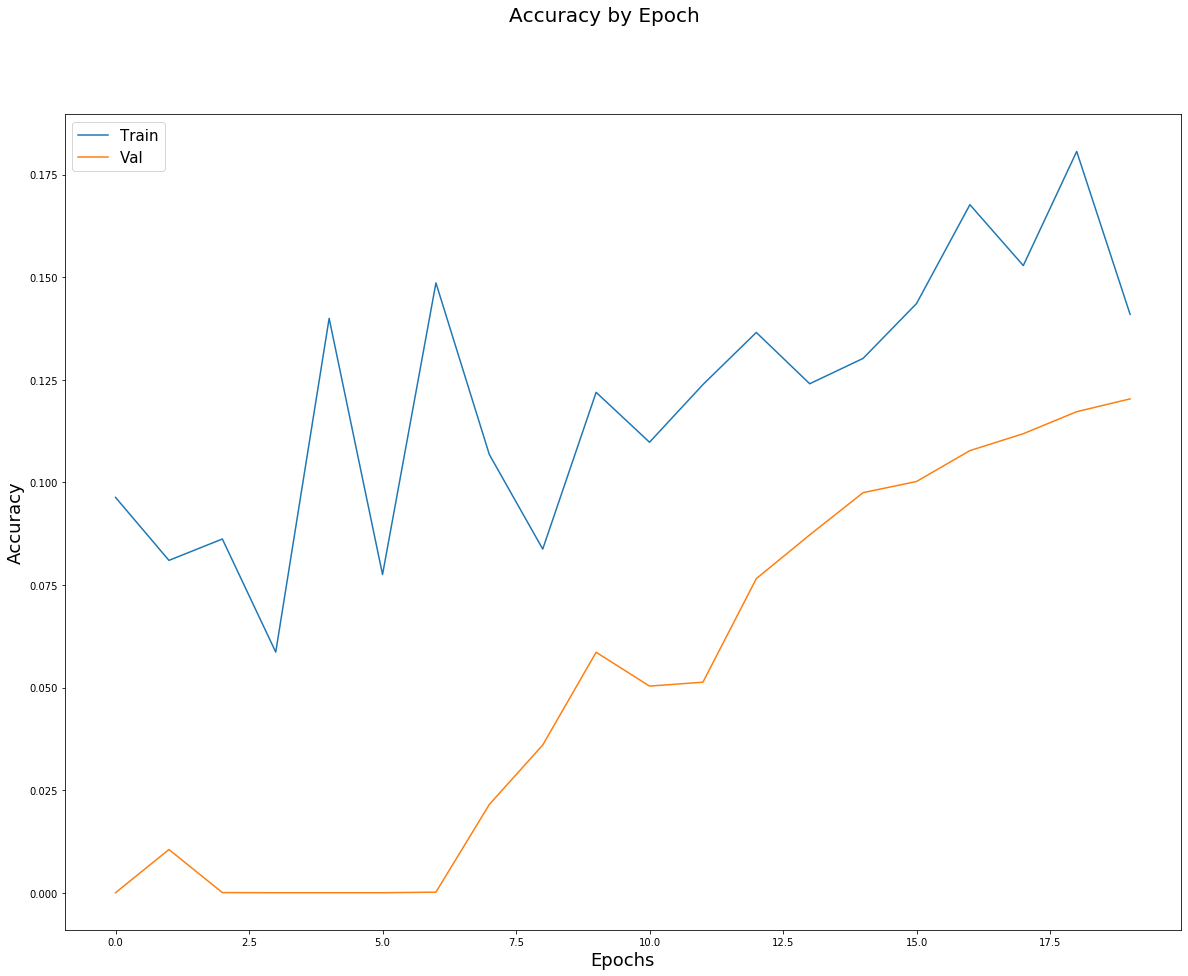

In [24]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print('Evaluating before training round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
        validation.keras_evaluate(state=server_state,
                                  val_dataset=val_data,
                                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                  vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  embedding_matrix=embedding_matrix,
                                  rnn_units=RNN_UNITS,
                                  metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
        train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
        train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
        # Save loss and accuracy from train and validation sets
        np.save('train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save('val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save('train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save('val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        # Save train sample stats
        np.save('num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
        np.save('num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
        np.save('num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
        
except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.show()

### Load Train Sample Stats

In [25]:
examples = np.load('num_examples.npy')
tokens = np.load('num_tokens.npy')
tokens_no_oov = np.load('num_tokens_no_oov.npy')

### Plot Train Sample Stats

In [26]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

In [27]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

<Figure size 432x288 with 0 Axes>

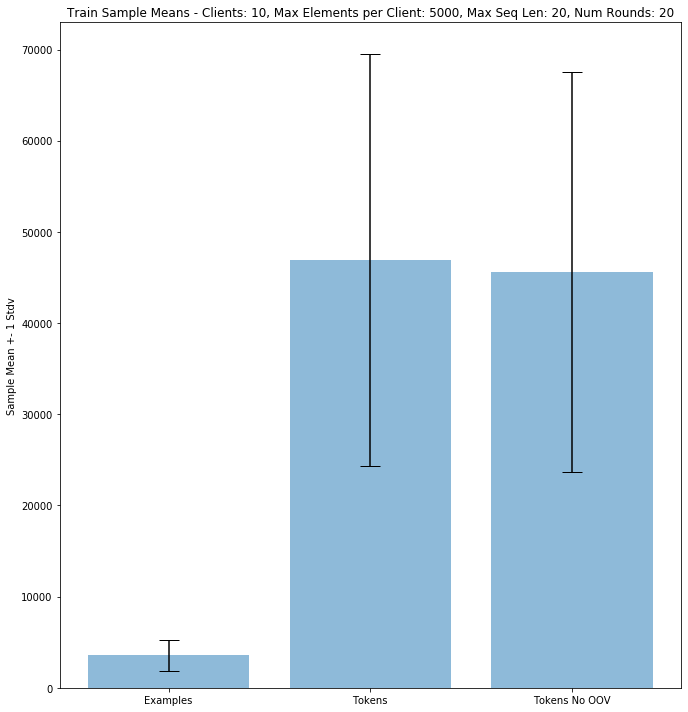

In [28]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig('500 Round Train Sample Means.png')
plt.show()

<Figure size 432x288 with 0 Axes>

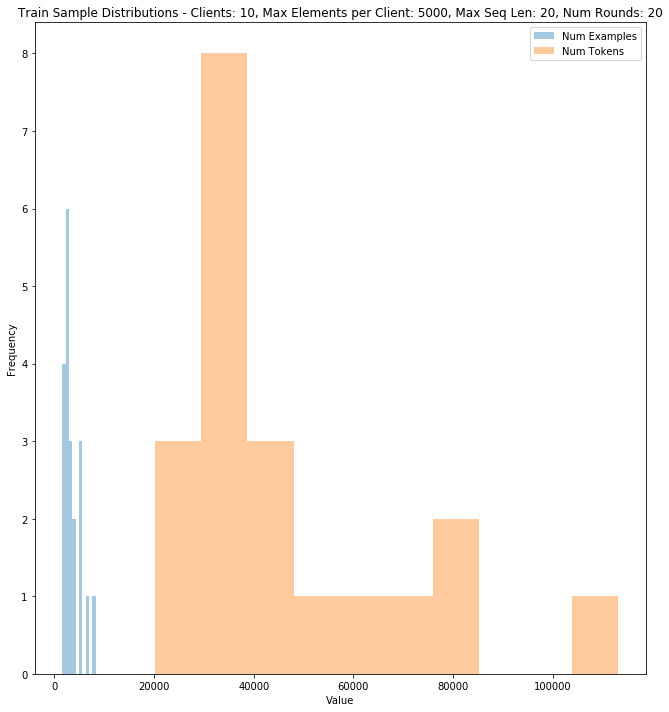

In [29]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('500 Round Train Sample Distributions.png')
plt.show()

<Figure size 432x288 with 0 Axes>

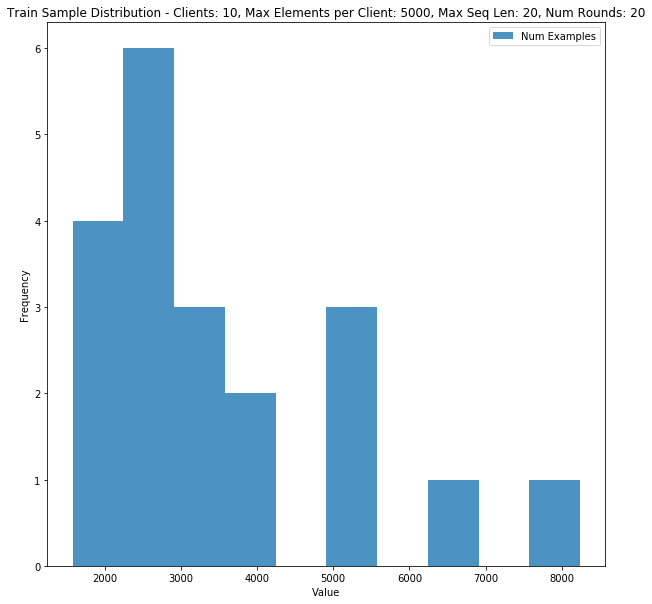

In [30]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

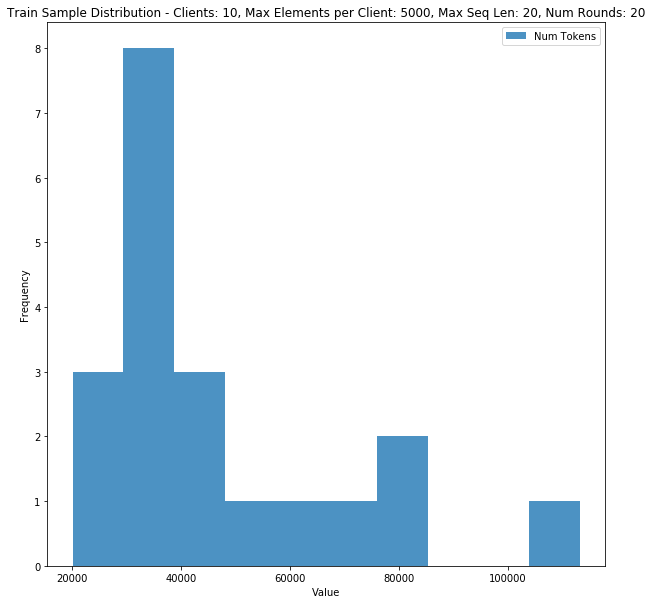

In [31]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

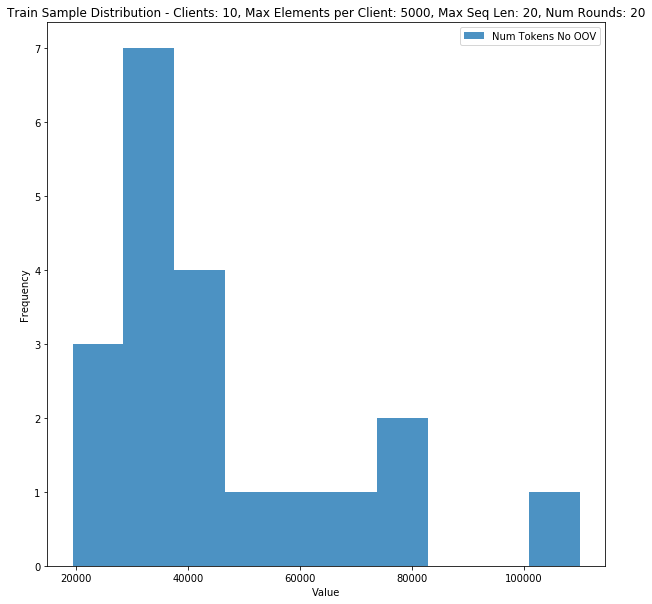

In [32]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

### Load Loss and Accuracy Arrays

In [33]:
train_loss = np.load('train_loss.npy')
train_accuracy = np.load('train_accuracy.npy')
val_loss = np.load('val_loss.npy')
val_accuracy = np.load('val_accuracy.npy')

### Validate Array Sizes

In [34]:
train_loss.shape

(20,)

In [35]:
train_accuracy.shape

(20,)

In [36]:
val_loss.shape

(20,)

In [37]:
val_accuracy.shape

(20,)